# FINITE ELEMENT - BOUNDARY CONDITION TESTING

In [1]:
### IMPORTATION PACKAGE
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
import math
import os
import sys
### LOCAL FUNCTION
### PLOTTING FUNCTION
def PlotDymamicSolution(xmax,ymax,vectorX,vectorY,nbData,evolution,vectorT):
    """ Function that allows to plot animate with a constant absisse vectorX (shape Nx1)
    and a solution evolving through time vectorY (shape NxnbData)."""
    # Set up the figure, the axis, and the plot element we want to animate
    fig = plt.figure()
    ax = plt.axes(xlim=(0, xmax), ylim=(0, ymax))
    line, = ax.plot([], [], lw=2)
    time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)
    # Initialization function: plot the background of each frame
    def Init():
        line.set_data([], [])
        time_text.set_text('')
        return line, time_text
    # Animation function.  This is called sequentially
    def Animate1DT(i):
        x = vectorX
        y = vectorY[:,i]
        line.set_data(x, y)
        time_text.set_text(evolution%vectorT[i])
        return line, time_text
    anim = animation.FuncAnimation(fig, Animate1DT, \
    init_func=Init,\
    frames=nbData, interval=50, blit=True)    
    # create the HTLM figure
    plt.close(anim._fig)
    HTML(anim.to_html5_video())
    # equivalent to rcParams['animation.html'] = 'html5'
    rc('animation', html='html5')
    return anim

# Discretization and initialisation

Suppose $b$ a known, strictly negative function 
(which corresponds to the case in Lifshitz-Slyozov where $0<b - \rho $), 
and suppose $\epsilon>$0. 

\begin{equation}
\label{eq:cas0}
\begin{cases}
 \displaystyle \frac{\partial u}{\partial t}
 -b(t) \frac{\partial u} {\partial x}  
 - \epsilon \frac{\partial^2 u} {\partial x^2}
 = 0  & \forall (x,t) \in [0,L] \times [0, \tau]\\
 u(x,0) = u_{0} (x) & \forall x \in [0,L] \\
 f(u)(0,t) = 0 & \forall t \in [0,\tau]\\
 u(L,t)=0 & \forall t \in [0,\tau]
\end{cases}
\end{equation}

In this paper, we compute the implicit finit element method $\mathbb{P}_1$ for different value of f : 
Dirichlet, Neumann, Robin and a dynamical (or transparent).

Let be $(x_0 =0 ,x_1,...,x_{N} = L)$ a regular mesh of $[0,L]$ 
for a no space $h$.
The finite dimension vector subspace of the absolute continuous and refined functions on each mesh is defined:

$$ V_h = \{ v \in C^1([0,L] | v_{|[x_i,x_{i+1}]} \in \mathbb{P}_1 \; \forall i \in [0,N_X-1] \} $$

We define the function $(\phi_j)$ with forms a basis for $V_h$ :

For $j\geq 1$ :

$$ \phi_j (x) = \begin{cases}
                 \displaystyle 1- \frac{|x-x_j|}{h} & |x-x_j| < h\\
				 0                                  & |x-x_j| \geq h
				 \end{cases}
$$

For $j=0$ : 
$$ \phi_0 (x) = \begin{cases}
                 \displaystyle 1- \frac{|x|}{h} & 0 < x < h \\
				 0                             &  x \geq h
				 \end{cases}
$$   

For $j=N$ : 
$$ \phi_N (x) = \begin{cases}
                 \displaystyle 1- \frac{|L-x|}{h} & 0 < |L-x| < h \\
				 0                                  & |L-x| \geq h
				 \end{cases}
$$   

 Let $v_h$ be the projection of an absolute continuous function $v$ on $V_h$, 
 $v_h$ is uniquely defined by the value of $v$ in its summits:
 

$$ v_h (x) = \sum_{i=0}^{N_X} v(x_i) \phi_i(x) $$
 
In addition, with the time discretization $n \in [ 0, N_T -1] $ and $t_n = n \delta t $ :
 
$$ u_h^n(x) = \sum_{j=0}^{N_X} u(x_j,t_n) \phi_j(x) $$

In [2]:
### PHYSICAL PARAMETERS
b = 2.0  # Depolymerisation speed
epsilon = 0.5
L = 10.0  # Domain size
T = 5.0  # Integration time

### NUMERICAL PARAMETERS
NT = 150  # Number of time steps
NX = 200  # Initial number of grid points
h = L/(NX+1)
deltat = T/NT

### INITIAL CONDITION
x = np.linspace(0.0,L,NX)
cmax = 0.1 # Maximum concentration of polymers
imax = 3/4*L
sigma = L/20
def Gaussienne(NX,c0,i0,s0):
    x = np.linspace(0.0,L,NX)
    gaussienne = c0*np.exp(-(x-i0)**2/(2*s0**2)) # Gaussienne
    gaussienne[0]=0
    return gaussienne


### VECTOR INITIALISATION
# Initial condition set as a gaussian
state_init = Gaussienne(NX,cmax,imax,sigma)


# FINITE ELEMENT : Matrix definition

The following matrices are defined:

$$
\begin{cases}
M_{ij} = \int_0^L \phi_i (x) \phi_j (x) dx \\
K_{ij} = \int_0^L \mathrm{d}_x \phi_i (x) \mathrm{d}_x \phi_j (x) dx \\
D_{ij} = \int_0^L  \phi_i (x) \mathrm{d}_x \phi_j (x)dx \\
\end{cases}
$$


Mass
$$ M = \frac{h}{6} \begin{pmatrix}
    2 & 1      & 0      &        & 0 \\
	1 & 4      & 1      &        &  \\
	  & \ddots & \ddots & \ddots &  \\
	  &        &      1 &    4   & 1 \\
   0  &        &        &     1  & 2 
\end{pmatrix} $$


Diffusion
$$ K = 1/h \begin{pmatrix}
    1 & -1     & 0      &        & 0 \\
   -1 & 2      & -1     &        &  \\
	  & \ddots & \ddots & \ddots &  \\
	  &        &     -1 &    2   & -1 \\
   0  &        &        &    -1  & 1 
\end{pmatrix} $$



Transport
$$ D = 1/2 \begin{pmatrix}
     -1 &  1     & 0      &        & 0 \\
   -1 &  0     &  1     &        &  \\
	  & \ddots & \ddots & \ddots &  \\
	  &        &     -1 &    0   & 1 \\
   0  &        &        &    -1  & 1 
\end{pmatrix} $$



In our application, we have for each simulation a homogene Dirichlet condition for $x=L$.

Different choices are possible to impose the Dirichlet condition in $x=L$. 
For our application,
since we don't want to manage a degree of freedom,
we opt for the elimination technique, 
i.e. the last row and the last column are deleted.
		
Another technique, known as \textbf{pseudo-elimination}, 
is to remove the dependencies between $\phi_N$ and $\phi_{N-1}$.
From a matrix point of view, this means deleting the last row and column 
which is replaced by a 1 on the diagonal.
Thus the value $u_h(L,t_n)=u_0(L)=0$ does not change.

Therefore,

$$ M = \frac{h}{6} \begin{pmatrix}
     2 &  1      &         \\
   1   &  4      &  \ddots  \\
	  &   \ddots &  \ddots 
\end{pmatrix} $$

$$ K =  \frac{1}{h} \begin{pmatrix}
     1 &  -1      &         \\
   -1   &  2      &   \ddots\\
	  &    \ddots &  \ddots 
\end{pmatrix} $$

$$ D =  \frac{1}{2} \begin{pmatrix}
   -1 &  1      &         \\
   -1   &  0      &  \ddots \\
	  &   \ddots  &  \ddots 
\end{pmatrix} $$

In [3]:
################################################################################
###                            ELEMENTS FINIS - P1

def FlowP1(nc,h,NX,deltat,b,epsilon):
    # We ignore the last element for which u(L,t) =0
    # 0 -- Transparent
    # 1 -- Dirichlet
    # 2 -- Neumann
    # 3 -- Robin
    # 4 -- Limit Model (transport)
    # Matrice de Masse
    M =h/6*(4*np.eye(NX)\
    +np.diag(np.ones(NX-1),1)\
    +np.diag(np.ones(NX-1),-1))
    if nc == 0 :
        M[0,0] = h/3
    if nc == 1 :
        pass
    if nc == 2 :
        M[0,0] = h/3
    if nc == 3 :
        M[0,0] = h/3
    if nc == 4 :
        M[0,0] = h/3
    # Matrice de rigidité 1
    # Diffusion
    K = 1/h*(2*np.eye(NX)\
    -np.diag(np.ones(NX-1),1)\
    -np.diag(np.ones(NX-1),-1))
    if nc == 0 :
        K[0,0] = 1/h
    if nc == 1 :
        pass
    if nc == 2 :
        K[0,0] = 1/h
    if nc == 3 :
        K[0,0] =-1
    if nc == 4 :
        K = np.zeros((NX,NX))
    # Matrice de rigidité 2
    # Transport
    D = 1/2*(\
    +np.diag(np.ones(NX-1),1)\
    -np.diag(np.ones(NX-1),-1))
    if nc == 0 :
        D[0,0] = -1/2
    if nc == 1 :
        pass
    if nc == 2 :
        D[0,0] = -1/2
    if nc == 4 :
        D[0,0] = -1/2
    # Matrice CL en x=0
    Do = np.zeros((NX,NX))
    if nc == 0:
        Do[0,0]=1
    #Flow computation
    flow = np.linalg.inv(M -deltat*b*D +deltat*epsilon*K +epsilon/b*Do).dot(M+epsilon/b*Do)
    return flow

    


# Transparent condition

$$ f(u)(0,t) = \displaystyle \frac{\partial u}{\partial t}|_{x=0}
 + v(t) \frac{\partial u}{\partial x}|_{x=0} = 0 $$ 

For $b= cste$, let's define the space
 $D = \left\{ (u,m)|  u\in H^1_R([0,L] \; m\in \mathbb{R}^+, \; u(0) =m \right\}$
 
We are looking for the bilinear form a such that:

$$ a((v,m_2),(u,m_1))=
\langle v , \partial_t u \rangle + \frac{\epsilon}{b}m_2\partial_t m_1 $$

And therefore :

$$ a((v,m_2),(u,m_1))=
\int_0^L b v(\partial_xu)
- \int_0^L \epsilon \partial_xv \partial_xu $$

Let be $u_h$ the projection of $u$ on $V_h$
and $v_h \in V_h$ a test vector.
The coordinates of the finction $u_h$ and $v_h$, respectively $U= (u_j)$ and $V= (v_j)$, are set on the basis of $(\phi_j, \delta_{0,j})$.

The variational formulation becomes:

$$ a(v_i \phi_i ,u_j \phi_j) = b v_i D_{ij} u_j - \epsilon v_i K_{ij} u_j $$

With a finite difference approximation for the time derivative,
the implicit schema is written:

$$ \langle v_h, \partial_t u_h \rangle = a(v_h,u_h)  $$

And therefore, for $j>0$ and $i>0$ :

$$ \displaystyle v_i M_{ij} \frac{1}{\delta t}(u_j^{n+1}-u_j^n)
= b v_i  D_{ij} u_j^{n+1} - \epsilon v_i K_{ij}u_j^{n+1} $$


For $j=0$ and $(\phi_0,1)$ : 

$$ \displaystyle v_i M_{i0} \frac{1}{\delta t}(u_0^{n+1}-u_0^n)
+ \frac{\epsilon}{b} v_i \delta_{i,0}\frac{1}{\delta t} (u_0^{n+1}-u_0^n) = b v_i  D_{i0} u_0^{n+1} - \epsilon v_i K_{i0}u_0^{n+1} $$

In conclusion, numerically we solve:

$$ U^{n+1} = (M -b \delta tD + \epsilon \delta t K + \frac{\epsilon}{b}D_0 )^{-1} (M+ \frac{\epsilon}{b}D_0)U^n $$

with $D_0$ :

$$ D_0 =  \begin{pmatrix}
     1 &  0      &         \\
   0   &  0      &        \\
	  &          &  \ddots 
\end{pmatrix} $$


In [4]:
### CL Transparent
statet = np.zeros((NX,NT))
statet[:,0] = state_init.copy()
flowt = FlowP1(0,h,NX,deltat,b,epsilon)
for i in range(0,NT-1):
    statet[:,i+1] = flowt.dot(statet[:,i])


In [5]:
### DATA VIZUALISATION ##########################################################

# First set up the figure, the axis, and the plot element we want to animate
transport1d = PlotDymamicSolution(L,1.1*np.amax(statet),np.linspace(0, L, NX),statet,\
                                  NT,'time = %.1f',np.linspace(0,T,NT))
# create the HTLM figure
plt.close(transport1d._fig)
HTML(transport1d.to_html5_video())
# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')
transport1d

# Neumann condition

$$ f(u)(0,t) = \partial_x u(0,t) = 0 $$


For $b= cste$, let's define the space
 $D = \left\{ u \in H^1_R([0,L]  \right\}$

 
$$\begin{split}
a(v,u) & = \langle v, b \frac{\partial y} {\partial x}  + \epsilon \frac{\partial^2 y} {\partial x^2} \rangle \\ 
       &= \int_0^L b v(\partial_xu) +  \int_0^L \epsilon v \partial_{xx}u \\
       &= \int_0^L b v(\partial_xu) +\epsilon [v \partial_xu]_0^L - \int_0^L \epsilon \partial_xv \partial_xu \\
	   &= \int_0^L b v(\partial_xu)  - \int_0^L \epsilon \partial_xv \partial_xu
\end{split}$$

Let be $u_h$ the projection of $u$ on $V_h$
and $v_h \in V_h$ a test vector.
The coordinates of $u_h$ and $v_h$, respectively $U$ and $V$, are set on the basis of $\phi_j$.
The variational formulation becomes:

$$a(v_h,u_h) = b V^T D U - \epsilon V^TKU $$



With a finite difference approximation for the time derivative,
the implicit schema is written:

$$ \langle v_h, \partial_t u_h \rangle = a(v_h,u_h)  $$

And therefore :

$$ \displaystyle V^TM\frac{1}{\delta t}(U^{n+1}-U^n)= b V^T D U^{n+1} - \epsilon V^TKU^{n+1} $$

$$ U^{n+1} = (M -b \delta tD + \epsilon \delta t K )^{-1} MU^n $$


In [6]:
### NEUMANN
staten = np.zeros((NX,NT))
staten[:,0] = state_init.copy()
flowt = FlowP1(2,h,NX,deltat,b,epsilon)
for i in range(0,NT-1):
    staten[:,i+1] = flowt.dot(staten[:,i])

### DATA VIZUALISATION ##########################################################

# First set up the figure, the axis, and the plot element we want to animate
transport1d = PlotDymamicSolution(L,1.1*np.amax(staten),np.linspace(0, L, NX),staten,\
                                  NT,'time = %.1f',np.linspace(0,T,NT))
# create the HTLM figure
plt.close(transport1d._fig)
HTML(transport1d.to_html5_video())
# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')
transport1d

# Dirichlet condition

$$ f(u)(0,t) = u(0,t) = 0 $$

For this classic condition, it is not necessary to introduce an increased space with a $m$ element.
The condition of 
Dirichlet does not appear in the variational formulation but in the space.
For $b= cste$, let's define the space
 $D = \left\{ u \in H^1([0,L] \; | \; u(0)=0,\; u(L)=0 \right\}$

We find again the same variationnal formulation :

$$ \begin{split}
a(v,u) & = \langle v, b \frac{\partial y} {\partial x}  + \epsilon \frac{\partial^2 y} {\partial x^2} \rangle \\ 
       &= \int_0^L b v(\partial_xu) +  \int_0^L \epsilon v \partial_{xx}u \\
       &= \int_0^L b v(\partial_xu) + \epsilon[v \partial_xu]_0^L - \int_0^L \epsilon \partial_xv \partial_xu \\
	   &= \int_0^L b v(\partial_xu)  - \int_0^L \epsilon \partial_xv \partial_xu
\end{split} $$



The equation integrating mass matrix and rigidity matrix is therefore written 
in the same way as in the case 
where the boundary condition in $x=0$ is dynamic (or transparent). 
However, for the resolution, 
we proceed by elimination method (or pseudo elimination), 
which amounts to adding after calculation a 0 to the first term.





In [7]:
### DIRICHLET
stated = np.zeros((NX,NT))
stated[:,0] = state_init.copy()
flowt = FlowP1(1,h,NX,deltat,b,epsilon)
for i in range(0,NT-1):
    stated[:,i+1] = flowt.dot(stated[:,i])

In [8]:
### DATA VIZUALISATION ##########################################################

# First set up the figure, the axis, and the plot element we want to animate
transport1d = PlotDymamicSolution(L,1.1*np.amax(statet),np.linspace(0, L, NX),stated,\
                                  NT,'time = %.1f',np.linspace(0,T,NT))
# create the HTLM figure
plt.close(transport1d._fig)
HTML(transport1d.to_html5_video())
# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')
transport1d

# Study of the limit $\epsilon \to 0$

### Definition of the limit system

Whe limit system to which we want to compare our conditions to the limits is as follows:

\begin{equation}
\label{eq:cas1}
\begin{cases}
 \displaystyle \frac{\partial u}{\partial t}
 -b(t) \frac{\partial y} {\partial x}  
 = 0  & \forall (x,t) \in [0,L] \times [0, \tau]\\
 u(x,0) = u_{0} (x) & \forall x \in [0,L] \\
 u(L,t)=0 & \forall t \in [0,\tau]
\end{cases}
\end{equation}

Of course the limit condition in $x=0$ has been removed.

$D = \left\{ u \in H^1([0,L] \; | \; u(L)=0 \right\}$

We find again the same variationnal formulation :

$$ 
a(v,u) = \langle v, b \frac{\partial y} {\partial x}   \rangle 
       = \int_0^L b v(\partial_xu)
 $$
 
 And therefore :

$$ \displaystyle V^TM\frac{1}{\delta t}(U^{n+1}-U^n)= b V^T D U^{n+1} $$

$$ U^{n+1} = (M -b \delta tD  )^{-1} MU^n $$



In [9]:
### Solution for eps =0
sv = np.zeros((NX,NT))
sv[:,0] = state_init.copy()
flow_v = FlowP1(4,h,NX,deltat,b,0)
for i in range(0,NT-1):
    sv[:,i+1] = flow_v.dot(sv[:,i])


            
# First set up the figure, the axis, and the plot element we want to animate
transport1d = PlotDymamicSolution(L,1.1*np.amax(sv),np.linspace(0, L, NX),sv,\
                                  NT,'time = %.1f',np.linspace(0,T,NT))
# create the HTLM figure
plt.close(transport1d._fig)
HTML(transport1d.to_html5_video())
# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')
transport1d

## NORM $L^2$

The we compare for norm $L^2$ the solution in $V_h$ :

$$ 
\begin{split}
\| u_{1h} - u_{2h} \| =& \int_0^L (u_1-u_2)^2 dx \\
                      =& \sum_{i=0}^N \sum_{j=0}^N(u_{1,i}-u_{2,i})(u_{1,j}-u_{2,j}) \int_0^L \phi_i \phi_j \\
                      =& (U_1 - U_2)^TM(U_1 - U_2)
\end{split}
$$

## NORM $H^1$

The we compare for norm $H^1$ the solution in $V_h$ :

$$ 
\begin{split}
\| u_{1h} - u_{2h} \| =& \int_0^L (u_1-u_2)^2 dx + \int_0^L \partial_x(u_1-u_2)^2 dx\\
                      =& \sum_{i=0}^N \sum_{j=0}^N(u_{1,i}-u_{2,i})(u_{1,j}-u_{2,j}) \int_0^L \phi_i \phi_j
                          +\sum_{i=0}^N \sum_{j=0}^N(u_{1,i}-u_{2,i})(u_{1,j}-u_{2,j}) 
                          \int_0^L \partial_x\phi_i \partial_x\phi_j\\
                      =& (U_1 - U_2)^TM(U_1 - U_2)+(U_1 - U_2)^TK(U_1 - U_2)
\end{split}
$$

[Text(0,0.5,'erreur'),
 Text(0.5,0,'epsilon/b'),
 Text(0.5,1,'L2 Error for different value of diffusion coefficient')]

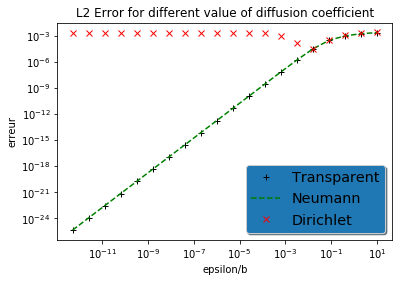

In [10]:
Npoint = 20
epsilon = np.logspace(-12,2,Npoint, endpoint=False)
k=0
st = np.zeros((NX,NT,Npoint))
sn = np.zeros((NX,NT,Npoint))
sd = np.zeros((NX,NT,Npoint))

### COMPUTATION OF THE NORM L2xL2 
normt=np.zeros(Npoint) # Transparent
normn=np.zeros(Npoint) # Neuman
normd=np.zeros(Npoint) # Dirichlet

# Mass matrix
M =h/6*(4*np.eye(NX)\
+np.diag(np.ones(NX-1),1)\
+np.diag(np.ones(NX-1),-1))
M[0,0] = h/3
G = np.exp(-np.square(np.linspace(0,L,NX)))
MG = M*G

for eps in epsilon:
    ### RESOLUTION : CL TRANSPARENT
    # state initialisation
    st[:,0,k] = state_init.copy()
    A = FlowP1(0,h,NX,deltat,b,eps)
    for i in range(0,NT-1):
        st[:,i+1,k] = A.dot(st[:,i,k])
        normt[k] += T/NT*np.sum(MG*np.square(st[:,i,k]- sv[:,i]))
    ### RESOLUTION : CL NEUMANN
    # state initialisation
    sn = np.zeros((NX,NT,Npoint))
    sn[:,0,k] = state_init.copy()
    A = FlowP1(2,h,NX,deltat,b,eps)
    for i in range(0,NT-1):
        sn[:,i+1,k] = A.dot(sn[:,i,k])
        normn[k] += T/NT*np.sum(MG*np.square(sn[:,i,k]- sv[:,i]))
    ### RESOLUTION : CL DIRICHLET
    # state initialisation
    sd = np.zeros((NX,NT,Npoint))
    sd[:,0,k] = state_init.copy()
    A = FlowP1(1,h,NX,deltat,b,eps)
    for i in range(0,NT-1):
        sd[:,i+1,k] = A.dot(sd[:,i,k])
        normd[k] += T/NT*np.sum(MG*np.square(sd[:,i,k]- sv[:,i]))
    ### INCREMENT
    k+=1


### PLOT
fig3, ax3 = plt.subplots()
ax3.loglog(epsilon*1/b, normt, 'k+', label= "Transparent")
ax3.loglog(epsilon*1/b, normn, 'g--', label="Neumann")
ax3.loglog(epsilon*1/b, normd, 'rx', label="Dirichlet")
legend = ax3.legend(loc='lower right', shadow=True, fontsize='x-large')
legend.get_frame().set_facecolor('C0')
ax3.set(xlabel='epsilon/b', ylabel='erreur',
       title='L2 Error for different value of diffusion coefficient')

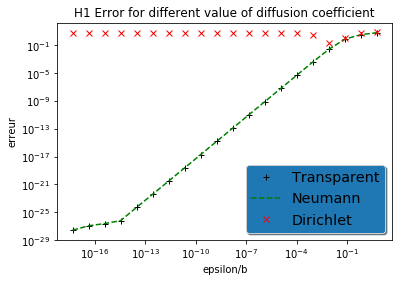